# Day vs Night Classifier using Pytorch

## Importing libs

In [48]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import shutil
from tqdm import tqdm

In [49]:
ROOT_DIR = '/content/gdrive/My Drive/scraped_dataset'
TRAINING_DIR = ROOT_DIR + '/training'
TESTING_DIR = ROOT_DIR + '/testing'

## Utilities


In [50]:
class DayNightDataset(Dataset):
    def __init__(self, img_data=None, root_dir = os.getcwd() + '/dataset/training', transform=None):
        assert img_data is not None
        if not os.path.exists(root_dir):
            raise OSError("Wrong Path for Dataset")

        self.root_dir = root_dir
        self.transform = transform
        self.img_data = img_data

         
    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        
        if self.img_data.loc[index, 'labels'] == 0:
            img_dir = self.root_dir + '/night'
        else:
            img_dir = self.root_dir + '/day'

        img_name = os.path.join(img_dir, self.img_data.loc[index, 'Images'])

        image = Image.open(img_name)
        label = torch.tensor(self.img_data.loc[index, 'labels']).to(torch.float32)

        if self.transform is not None:
            image = self.transform(image)
        return image, label


In [51]:
def get_train_df(root_dir):
    images = []
    labels = [] 

    for category in os.listdir(root_dir):
        
        if category == 'day':
            for file in os.listdir(os.path.join(root_dir, category)):
                images.append(file)
                labels.append(1)
            
        elif category == 'night':
            for file in os.listdir(os.path.join(root_dir, category)):
                images.append(file)
                labels.append(0)

        else:
            raise OSError("Non Supported Category")

    data = {'Images': images, 'labels': labels}
    df = pd.DataFrame(data)

    return df


In [52]:
def vis_sample(sample):
    img, label = sample

    f, ax = plt.subplots(1, 1, figsize=(10,7))
    ax.imshow(img)
    label = ('Label: Night' if not label else 'Label: day')
    ax.set_title(label)
    plt.show()

In [53]:
def get_accuracy(loader, net, device):

    num_correct = 0
    num_samples = 0
    net.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = net(x)
            pred_ = torch.tensor([1.0 if i >= 0.5 else 0.0 for i in scores]).to(device)
            num_correct += (pred_ == y).sum()
            num_samples += pred_.size(0)

    # print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
    
    net.train()
    acc = ( float(num_correct) / float(num_samples) ) * 100
    return acc


## Linking drive to colab

In [54]:
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/My Drive'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Loading Dataset as pandas frame

In [55]:
df = get_train_df(TRAINING_DIR)
df.head(), df.tail(), len(df), df['labels'].unique(), sum(df['labels'] == 1), sum(df['labels'] == 0) 

(           Images  labels
 0  3c3c484df0.jpg       1
 1  0f09d0fde0.jpg       1
 2  0d7ce3c79e.jpg       1
 3  eeb8d67900.jpg       1
 4  9ea6801b53.jpg       1,               Images  labels
 1003  ad366fe44f.jpg       0
 1004  cb18d1986f.jpg       0
 1005  e965b784a1.jpg       0
 1006  3c02b7a2fa.jpg       0
 1007  2ad92799df.jpg       0, 1008, array([1, 0]), 509, 499)

## Visualization 

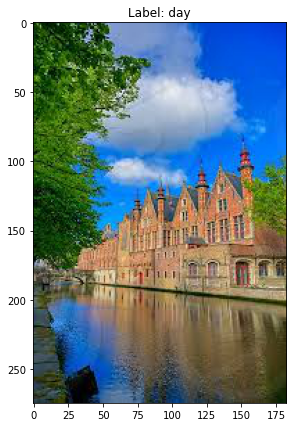

In [56]:
# Visualizing random samples
import random
n_samples = 1
obj = DayNightDataset(df, TRAINING_DIR)

for i in range(n_samples):
    sample_index = random.randint(0, len(df))

    vis_sample(obj[sample_index])

## Hyper Parameters 

In [63]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 32
SPLIT_RATIO = .2
SHUFFLE = True

n_epochs = 32
learning_rate = 0.0001
betas = (0.9, 0.999)

device

'cuda'

## Splitting Data to Train/Val

In [64]:
indices = list(range(len(df)))

split = int(np.floor(SPLIT_RATIO * len(df)))

if SHUFFLE:
    np.random.shuffle(indices)
    
train_indices, val_indices = indices[split:], indices[:split]

In [65]:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

## Transformation & Data Loading

In [66]:
transform_pipeline = transforms.Compose(
                    [
                      transforms.Resize((224,224)),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

In [67]:
dataset = DayNightDataset(df, TRAINING_DIR, transform=transform_pipeline)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
len(train_loader), len(val_loader)

(26, 7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


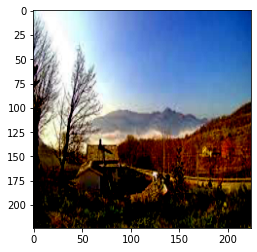

(torch.Size([3, 224, 224]), torch.float32)

In [68]:
## Vis. Sample after transformation
img_t = dataset[15][0]
plt.imshow(img_t.permute(1,2,0))
plt.show()
img_t.shape, img_t.dtype

## Model Definition using Resnet101

In [69]:
class Model(nn.Module):
    def __init__(self, num_classes = 1):
        super(Model, self).__init__()
        self.res_net = models.resnet101(pretrained=True)
        num_ftrs = self.res_net.fc.in_features
        
        self.res_net.fc = nn.Linear(num_ftrs, 1024)
        self.final_layers = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(256, num_classes),
                                 nn.Sigmoid())
        
    def forward(self, X):
        out = self.res_net(X)
        return self.final_layers(out).squeeze(-1)

In [70]:
net = Model().to(device)
crit = nn.BCELoss()

In [71]:
optim = optim.Adam(params=net.parameters(), lr=learning_rate, betas=betas)

In [72]:
net

Model(
  (res_net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [73]:
for name, param in net.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True

    elif "layer4" in name or "layer3" in name:
        param.requires_grad = True

    elif name.startswith("final_layers"):
        param.requires_grad = True

    else:
        param.requires_grad = False 

# for name, param in net.res_net.named_parameters():
    print(name, param.requires_grad)

res_net.conv1.weight False
res_net.bn1.weight False
res_net.bn1.bias False
res_net.layer1.0.conv1.weight False
res_net.layer1.0.bn1.weight False
res_net.layer1.0.bn1.bias False
res_net.layer1.0.conv2.weight False
res_net.layer1.0.bn2.weight False
res_net.layer1.0.bn2.bias False
res_net.layer1.0.conv3.weight False
res_net.layer1.0.bn3.weight False
res_net.layer1.0.bn3.bias False
res_net.layer1.0.downsample.0.weight False
res_net.layer1.0.downsample.1.weight False
res_net.layer1.0.downsample.1.bias False
res_net.layer1.1.conv1.weight False
res_net.layer1.1.bn1.weight False
res_net.layer1.1.bn1.bias False
res_net.layer1.1.conv2.weight False
res_net.layer1.1.bn2.weight False
res_net.layer1.1.bn2.bias False
res_net.layer1.1.conv3.weight False
res_net.layer1.1.bn3.weight False
res_net.layer1.1.bn3.bias False
res_net.layer1.2.conv1.weight False
res_net.layer1.2.bn1.weight False
res_net.layer1.2.bn1.bias False
res_net.layer1.2.conv2.weight False
res_net.layer1.2.bn2.weight False
res_net.layer1

## Training Loop 

In [74]:
def training_loop(net, crit, optim, train_loader, val_loader, device='cpu', n_epochs=32):
    
    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []

    for epoch in range(n_epochs):
        net.train()
        loop = tqdm(train_loader)
        running_loss = 0.0
        num_correct = 0.
        num_samples = 0.

        for imgs, labels in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            # Forwarding input through model
            outs = net(imgs)
            loss = crit(outs, labels)
            running_loss += loss.to('cpu').detach().numpy()
            
            loop.set_description(f"Epoch [{epoch}/{n_epochs}]")
            loop.set_postfix(loss = f"Training Loss: {loss}")

            # Model backward prop. & updating
            optim.zero_grad()
            loss.backward()
            optim.step()
      
        train_loss.append(running_loss / len(train_loader))
        train_acc.append( get_accuracy(train_loader, net, device) )

        running_loss = 0.0
        with torch.no_grad():
            net.eval()

            loop = tqdm(val_loader)
            for val_data, val_label in loop:
                val_data = val_data.to(device)
                val_label = val_label.to(device)

                val_outputs = net(val_data)
                loss = crit(val_outputs, val_label)
                loop.set_postfix(loss = f"Validation Loss: {loss}")
                running_loss += loss.to('cpu').detach().numpy()

        val_loss.append(running_loss / len(val_loader))
        val_acc.append(get_accuracy(val_loader, net , device))

    return train_loss, train_acc, val_loss, val_acc

In [75]:
train_loss, train_acc, val_loss, val_acc = training_loop(net, crit, optim, train_loader, val_loader=val_loader, 
                                                         device=device, n_epochs=n_epochs)

100%|██████████| 7/7 [00:02<00:00,  2.87it/s, loss=Validation Loss: 0.0017065879656001925]


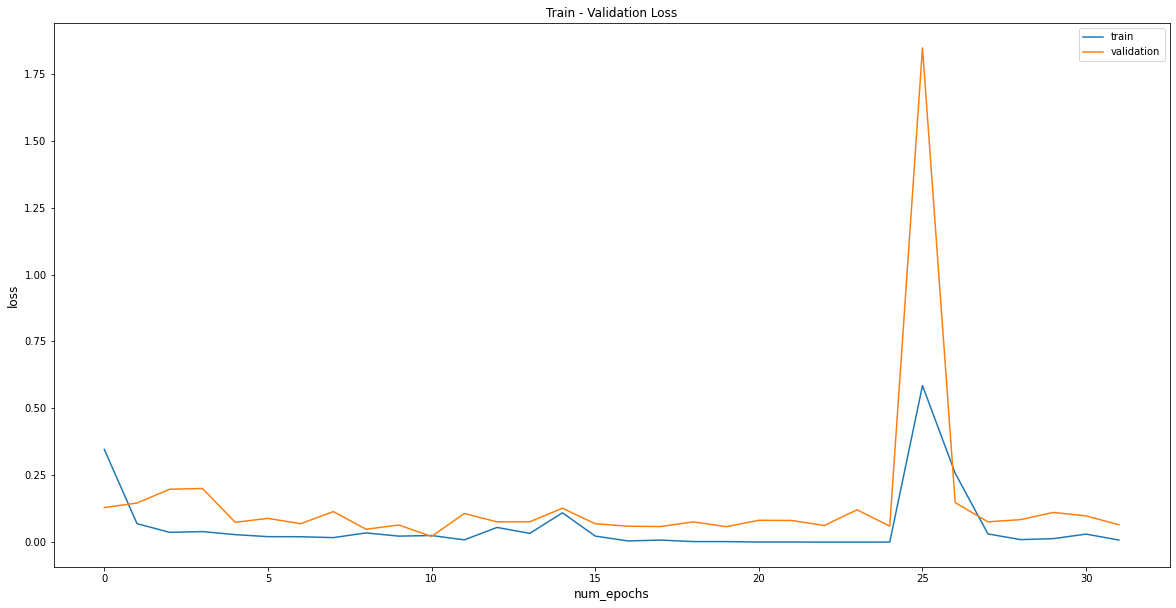

In [76]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend()

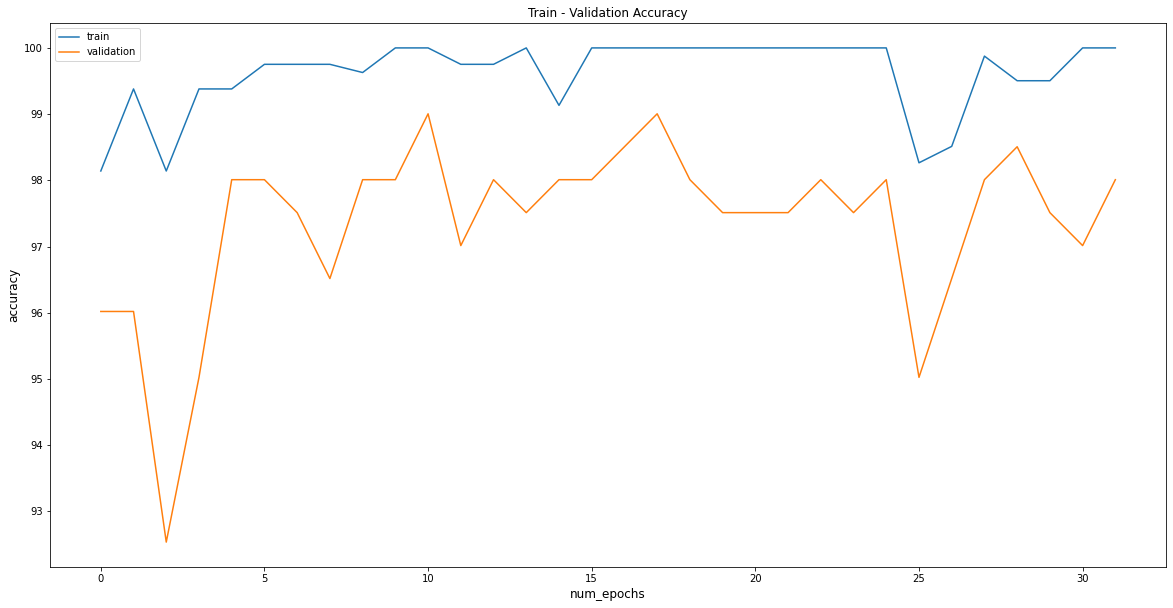

In [77]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend()

In [78]:
torch.save(net.state_dict(), os.getcwd() + '/resnet_101_32_epoch.pth')

## Testing

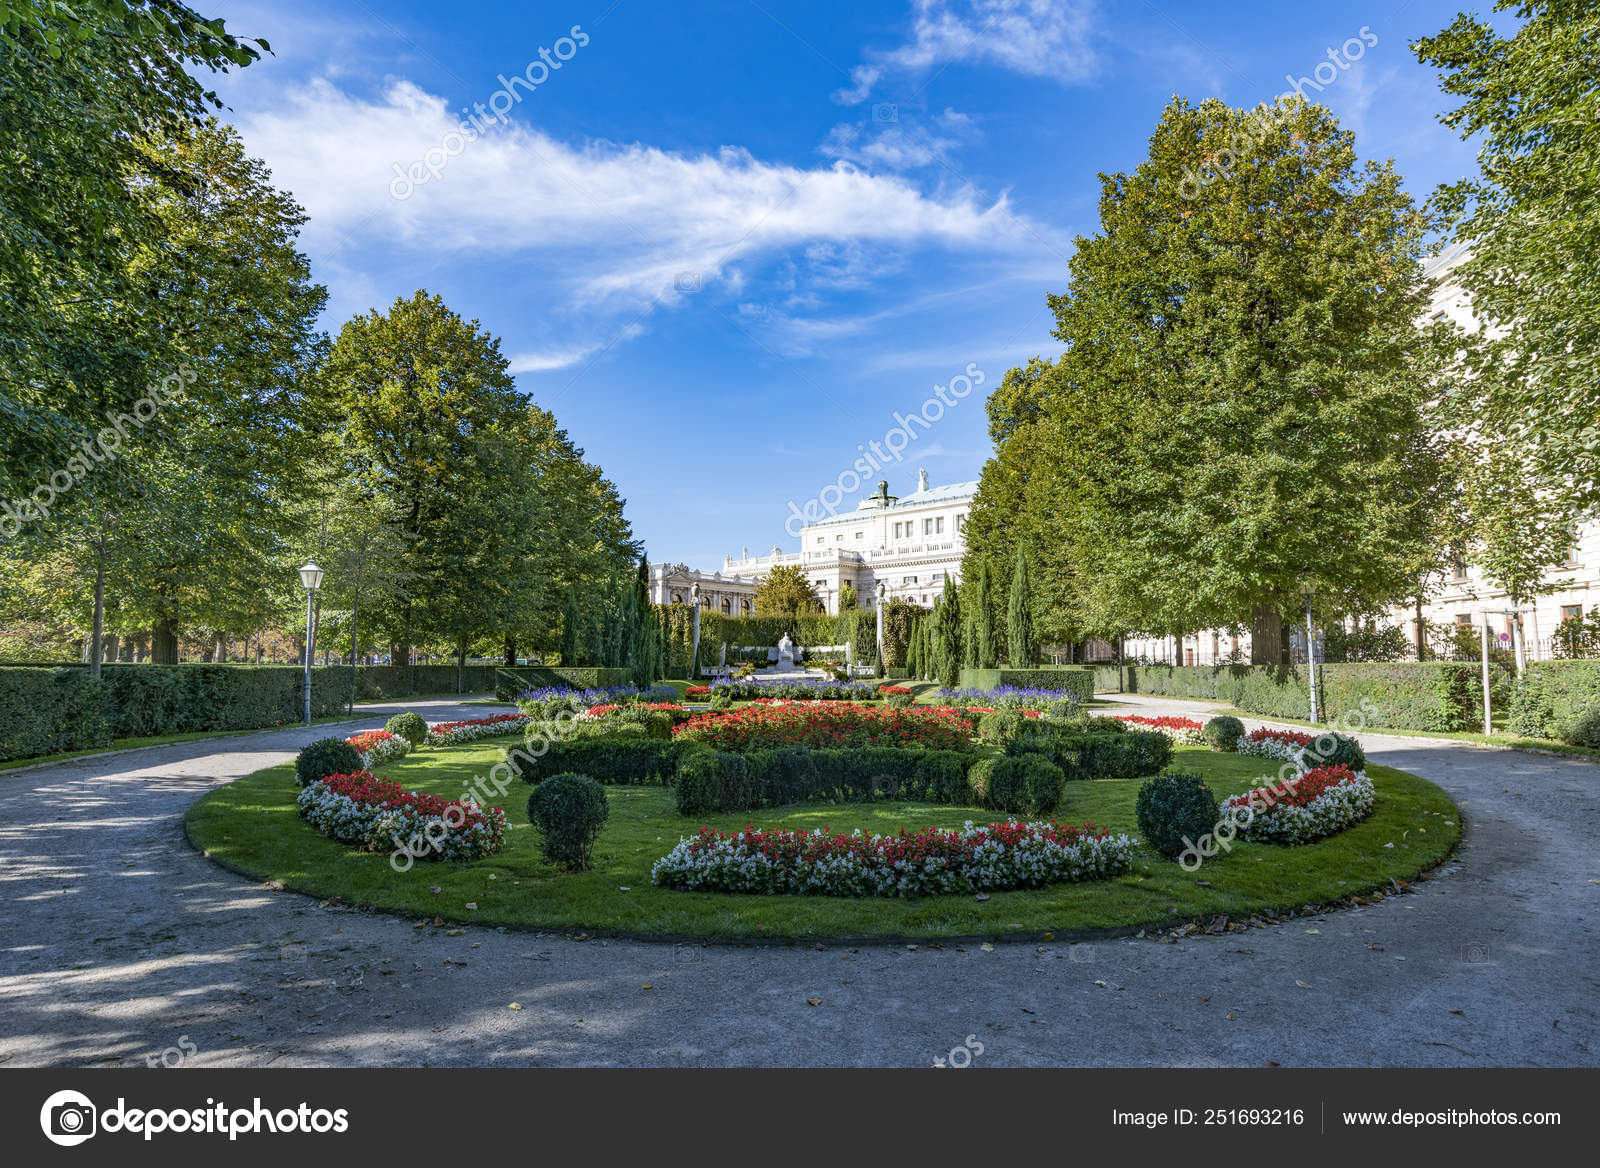

In [79]:
list_testing_imgs = os.listdir(TESTING_DIR + '/day') 
img_ = Image.open(TESTING_DIR + '/day/' + list_testing_imgs[31])
img_

In [80]:
trans = transforms.Compose([
                            transforms.Resize((224,224)),
                            transforms.ToTensor()
])
img_ = trans(img_)
img_ = img_.unsqueeze(0).to(device)

In [81]:
with torch.no_grad():
  net.eval().to(device)
  pred_ = net(img_)
  pred_ = float(pred_.cpu().detach().numpy())
  if pred_ < 0.5:
    print("Night With Confidence Score: ", 1 - pred_)
  else:
    print("Day With Confidence Score: ", pred_)

Day With Confidence Score:  1.0
